In [1]:
import pandas as pd
import numpy as np
import gensim
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE

C:\Users\Bowler\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
train_orders = pd.read_csv('./order_products__train.csv')
prior_orders = pd.read_csv('./order_products__prior.csv')
products = pd.read_csv('./products.csv').set_index('product_id')

In [3]:
train_orders['product_id'] = train_orders['product_id'].astype(str)
prior_orders['product_id'] = prior_orders['product_id'].astype(str)

In [4]:
train_products = train_orders.groupby('order_id').apply(lambda order: order['product_id'].tolist())
prior_products = prior_orders.groupby('order_id').apply(lambda order: order['product_id'].tolist())

In [5]:
train_products.head()

order_id
1     [49302, 11109, 10246, 49683, 43633, 13176, 472...
36    [39612, 19660, 49235, 43086, 46620, 34497, 486...
38    [11913, 18159, 4461, 21616, 23622, 32433, 2884...
96    [20574, 30391, 40706, 25610, 27966, 24489, 39275]
98    [8859, 19731, 43654, 13176, 4357, 37664, 34065...
dtype: object

In [6]:
type(train_products)

pandas.core.series.Series

In [7]:
prior_products.head()

order_id
2    [33120, 28985, 9327, 45918, 30035, 17794, 4014...
3    [33754, 24838, 17704, 21903, 17668, 46667, 174...
4    [46842, 26434, 39758, 27761, 10054, 21351, 225...
5    [13176, 15005, 47329, 27966, 23909, 48370, 132...
6                                [40462, 15873, 41897]
dtype: object

In [8]:
products.head()

,product_name,aisle_id,department_id
product_id,,,
1,Chocolate Sandwich Cookies,61,19
2,All-Seasons Salt,104,13
3,Robust Golden Unsweetened Oolong Tea,94,7
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
5,Green Chile Anytime Sauce,5,13


In [9]:
sentences = prior_products.append(train_products).values

In [11]:
sentences[:5]

array([ ['33120', '28985', '9327', '45918', '30035', '17794', '40141', '1819', '43668'],
       ['33754', '24838', '17704', '21903', '17668', '46667', '17461', '32665'],
       ['46842', '26434', '39758', '27761', '10054', '21351', '22598', '34862', '40285', '17616', '25146', '32645', '41276'],
       ['13176', '15005', '47329', '27966', '23909', '48370', '13245', '9633', '27360', '6348', '40878', '6184', '48002', '20914', '37011', '12962', '45698', '24773', '18569', '41176', '48366', '47209', '46522', '38693', '48825', '8479'],
       ['40462', '15873', '41897']], dtype=object)

In [12]:
type(sentences)

numpy.ndarray

In [13]:
model = gensim.models.Word2Vec(sentences, size=100, window=5, min_count=5, workers=4)

In [14]:
# Organize data for visualization
vocab = list(model.wv.vocab.keys())
suggestions = model.most_similar(positive=[vocab[1]], topn=5)

C:\Users\Bowler\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
vocab[:5]

['33120', '28985', '9327', '45918', '30035']

In [16]:
type(suggestions)

list

In [17]:
suggestions[:5]

[('27521', 0.8549759387969971),
 ('35547', 0.7498105764389038),
 ('35535', 0.747579038143158),
 ('26800', 0.7336131930351257),
 ('27104', 0.7158852815628052)]

In [18]:
def get_batch(vocab, model, n_batches=3):
    output = list()
    for i in range(0, n_batches):
        rand_int = np.random.randint(len(vocab), size=1)[0]
        suggestions = model.most_similar(positive=[vocab[rand_int]], topn=5)
        suggest = list()
        for i in suggestions:
            suggest.append(i[0])
        output += suggest
        output.append(vocab[rand_int])
    return output

In [19]:
def plot_with_labels(low_dim_embs, labels, filename='tsne.png'):
    '''From Tensorflow's tutorial.'''
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18))  #in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i,:]
        plt.scatter(x, y)
        plt.annotate(label,
                     xy=(x, y),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
#     plt.savefig(filename)
    plt.show()

C:\Users\Bowler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """
C:\Users\Bowler\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


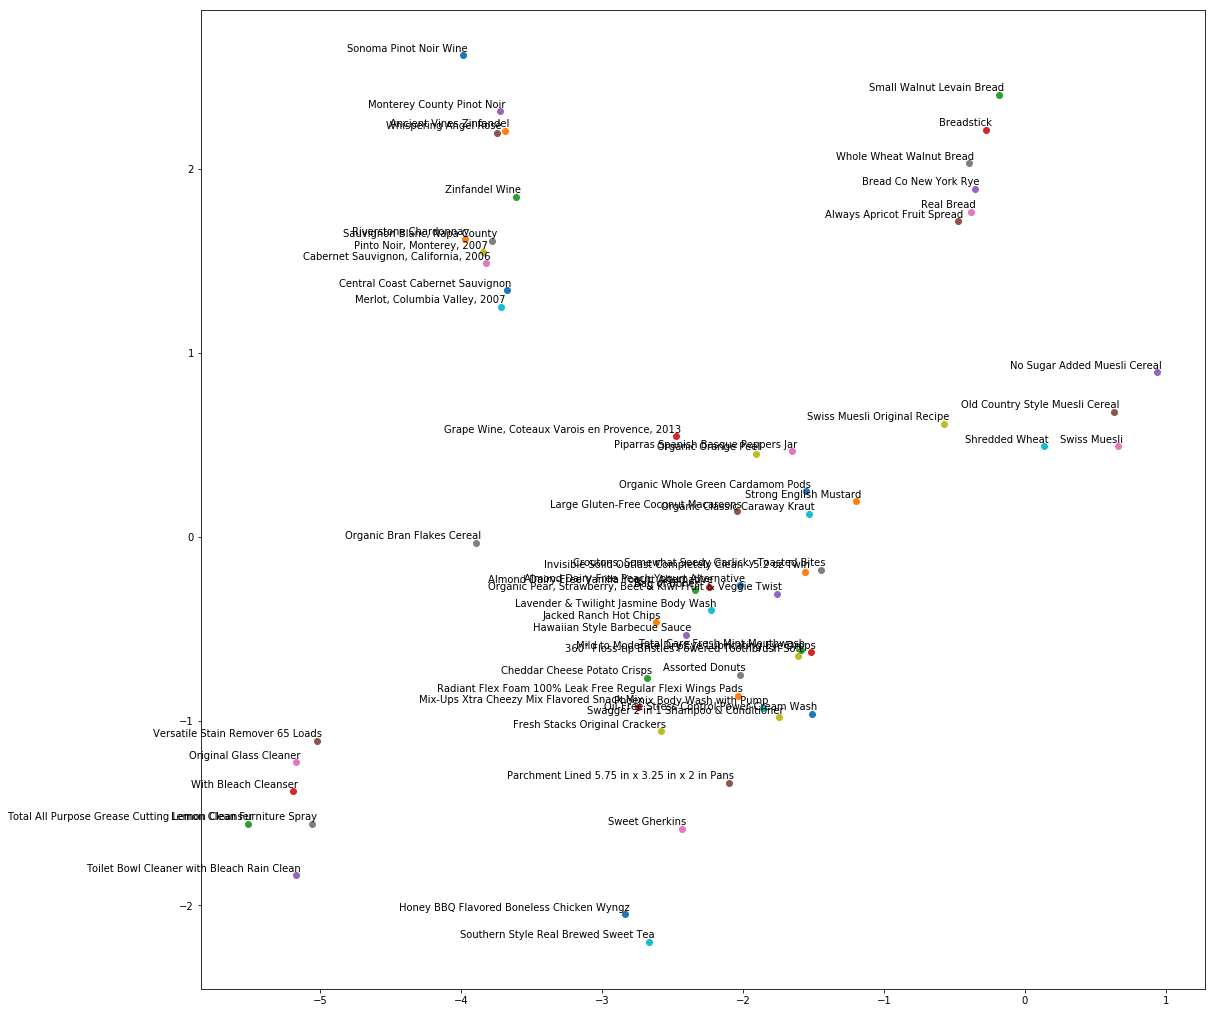

In [20]:
tsne = TSNE()
embeds = []
labels = []
for item in get_batch(vocab, model, n_batches=10):
    embeds.append(model[item])
    labels.append(products.loc[int(item)]['product_name'])
embeds = np.array(embeds)

embeds = tsne.fit_transform(embeds)
plot_with_labels(embeds, labels)

In [21]:
import sklearn as sk
import pickle

In [22]:
pca = sk.decomposition.PCA(11)
pca.fit(model.wv[vocab])
pca.explained_variance_ratio_
product2vec = pca.transform(model.wv[vocab])
product2vec = pd.DataFrame(product2vec)
product2vec.columns = ['pca_' + str(s) for s in product2vec.columns.tolist()]
product2vec['product_id'] = vocab

In [23]:
product2vec['product_id'] = product2vec['product_id'].astype(int)

In [24]:
type(product2vec)

pandas.core.frame.DataFrame

In [25]:
product2vec.head()

,pca_0,pca_1,pca_2,pca_3,pca_4,pca_5,pca_6,pca_7,pca_8,pca_9,pca_10,product_id
0,9.801101,0.568328,2.504000,-1.319293,0.887776,-2.607211,0.988781,1.643225,0.824668,-0.129804,-1.881939,33120
1,7.413322,5.120133,2.234532,0.543865,2.318910,-3.052235,0.732555,1.574005,0.262772,0.438550,-0.989163,28985
2,0.406174,6.790894,-0.507241,-1.217363,-1.462475,-0.762630,-0.659676,-0.694346,-1.128357,-1.566246,1.342802,9327
3,4.640899,2.033126,-3.932300,-4.187489,2.076172,0.833186,-0.484909,1.865404,0.323753,-2.229594,-0.124903,45918
4,2.596891,0.185762,1.231750,-2.258580,1.824726,-0.315615,1.404920,-0.466321,-0.713475,-0.321949,0.990373,30035


In [14]:
pickle.dump(product2vec, open('product2vec.p', 'wb'))